# Example 2: 1st-level Analysis

In this example, we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

## Imports

First, we need to import all the modules we later want to use.

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [2]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# TR of functional images
with open('/home/neuro/workshop/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):

In [4]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

## Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [5]:
!cat /home/neuro/workshop/data/ds000114/task-fingerfootlips_events.tsv

onset	duration	weight	trial_type
10	15.0	1	Finger
40	15.0	1	Foot
70	15.0	1	Lips
100	15.0	1	Finger
130	15.0	1	Foot
160	15.0	1	Lips
190	15.0	1	Finger
220	15.0	1	Foot
250	15.0	1	Lips
280	15.0	1	Finger
310	15.0	1	Foot
340	15.0	1	Lips
370	15.0	1	Finger
400	15.0	1	Foot
430	15.0	1	Lips


We can also create a data frame using pandas library.

In [6]:
import pandas as pd
trialinfo = pd.read_table('/home/neuro/workshop/data/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


And finally we need to separate the onsets of the three conditions, i.e. group by ``trial_type``. This can be done as follows:

In [7]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)

('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)

('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)



Now, let us incorporate all this in the helper function ``subjectinfo``.

In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/home/neuro/workshop/data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'sub-{subject_id}_ses-test_task-{task_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}', 
                             'art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [10]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

211018-11:31:52,0 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


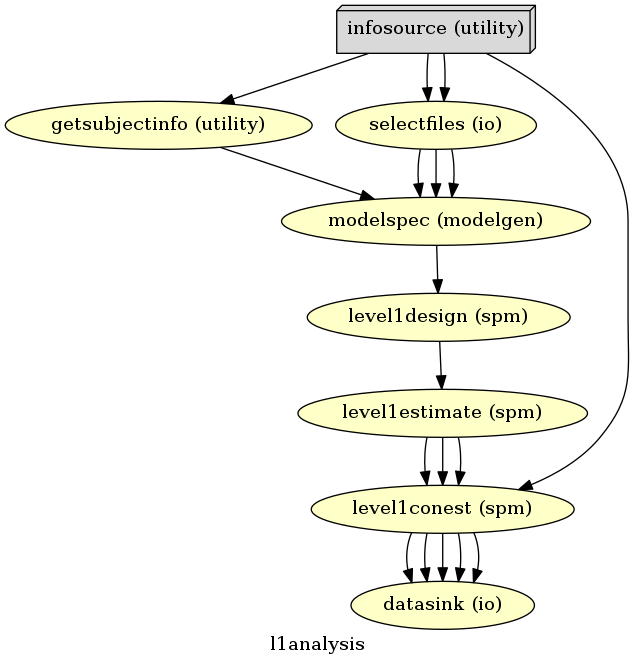

In [11]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [12]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

211018-11:31:55,229 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
211018-11:31:55,364 nipype.workflow INFO:
	 Running in parallel.
211018-11:31:55,372 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 40 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-11:31:55,509 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_10/selectfiles".
211018-11:31:55,509 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_10/getsubjectinfo".
211018-11:31:55,509 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_10/selectfiles".
211018-11:31:55,508 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_10/getsubjectinfo".
211018-11:31:55,52

211018-11:32:14,721 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
211018-11:32:14,800 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
211018-11:32:15,412 nipype.workflow INFO:
	 [Job 3] Completed (l1analysis.level1design).
211018-11:32:15,413 nipype.workflow INFO:
	 [Job 10] Completed (l1analysis.level1design).
211018-11:32:15,417 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 34 jobs ready. Free memory (GB): 4.83/5.23, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
211018-11:32:15,519 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_10/level1estimate".
211018-11:32:15,519 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_10/level1estimate".
211018-11:32:15,538 nipype.workflo

211018-11:32:55,827 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_10/spmT_0002.nii -> /output/datasink/1stLevel/sub-10/fwhm-4/spmT_0002.nii
211018-11:32:55,830 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_10/spmT_0003.nii -> /output/datasink/1stLevel/sub-10/fwhm-4/spmT_0003.nii
211018-11:32:55,832 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_10/spmT_0004.nii -> /output/datasink/1stLevel/sub-10/fwhm-4/spmT_0004.nii
211018-11:32:55,839 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_10/spmT_0005.nii -> /output/datasink/1stLevel/sub-10/fwhm-4/spmT_0005.nii
211018-11:32:55,843 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_10/spmT_0006.nii -> /output/datasink/1stLevel/sub-10/fwhm-4/spmT_0006.nii
211018-11:32:55,847 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_10/spmT_0007.nii -> /output/datasink/1stLe

211018-11:32:57,857 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_09/con_0001.nii -> /output/datasink/1stLevel/sub-09/fwhm-8/con_0001.nii
211018-11:32:57,862 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_09/con_0002.nii -> /output/datasink/1stLevel/sub-09/fwhm-8/con_0002.nii
211018-11:32:57,858 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_10/spmF_0008.nii -> /output/datasink/1stLevel/sub-10/fwhm-8/spmF_0008.nii
211018-11:32:57,865 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_09/con_0003.nii -> /output/datasink/1stLevel/sub-09/fwhm-8/con_0003.nii
211018-11:32:57,865 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_10/spmF_0009.nii -> /output/datasink/1stLevel/sub-10/fwhm-8/spmF_0009.nii
211018-11:32:57,868 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_10/con_0001.nii -> /output/datasink/1stLevel/sub

211018-11:32:59,838 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_09/spmF_0008.nii -> /output/datasink/1stLevel/sub-09/fwhm-4/spmF_0008.nii
211018-11:32:59,841 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_09/spmF_0009.nii -> /output/datasink/1stLevel/sub-09/fwhm-4/spmF_0009.nii
211018-11:32:59,843 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_09/con_0001.nii -> /output/datasink/1stLevel/sub-09/fwhm-4/con_0001.nii
211018-11:32:59,847 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_09/con_0002.nii -> /output/datasink/1stLevel/sub-09/fwhm-4/con_0002.nii
211018-11:32:59,848 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_09/con_0003.nii -> /output/datasink/1stLevel/sub-09/fwhm-4/con_0003.nii
211018-11:32:59,851 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_09/con_0004.nii -> /output/datasink/1stLevel/sub

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211018-11:33:02,109 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:33:02,110 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:33:02,160 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
211018-11:33:03,648 nipype.workflow INFO:
	 [Job 30] Completed (l1analysis.modelspec).
211018-11:33:03,650 nipype.workflow INFO:
	 [Job 37] Completed (l1analysis.modelspec).
211018-11:33:03,653 nipype.workflow INFO:
	 [Job 42] Completed (l1analysis.getsubjectinfo).
211018-11:33:03,656 nipype.workflow INFO:
	 [Job 43] Completed (l1analysis.selectfiles).
211018-11:33:03,660 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 29 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-11:33:03,768 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_08/level1design".
211018-11:33:03,769 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1des

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211018-11:33:03,821 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211018-11:33:03,826 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211018-11:33:03,841 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:33:05,651 nipype.workflow INFO:
	 [Job 44] Completed (l1analysis.modelspec).
211018-11:33:05,655 nipype.workflow INFO:
	 [Job 49] Completed (l1analysis.getsubjectinfo).
211018-11:33:05,662 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 26 jobs ready. Free memory (GB): 4.83/5.23, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
211018-11:33:05,787 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_07/selectfiles".
211018-11:33:05,785 nipype.workflow INFO:
	 [Node] Setting

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211018-11:33:07,909 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:33:09,655 nipype.workflow INFO:
	 [Job 51] Completed (l1analysis.modelspec).
211018-11:33:09,661 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 4.63/5.23, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
211018-11:33:09,771 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_07/level1design".
211018-11:33:09,832 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211018-11:33:11,658 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 4.43/5.23, Free processors: 0/4.
                     Currently running:
                       * l1analysis

211018-11:34:07,869 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_08/datasink".
211018-11:34:07,869 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_08/datasink".
211018-11:34:07,877 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_07/datasink".
211018-11:34:07,937 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-11:34:07,938 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-11:34:07,950 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_08/SPM.mat -> /output/datasink/1stLevel/sub-08/fwhm-8/SPM.mat
211018-11:34:07,951 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_08/SPM.mat -> /output/datasink/1stLevel/sub-08/fwhm-4/SPM.mat
211018-11:

211018-11:34:08,40 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_08/spmF_0008.nii -> /output/datasink/1stLevel/sub-08/fwhm-8/spmF_0008.nii
211018-11:34:08,43 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_07/con_0004.nii -> /output/datasink/1stLevel/sub-07/fwhm-8/con_0004.nii
211018-11:34:08,46 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_08/con_0003.nii -> /output/datasink/1stLevel/sub-08/fwhm-4/con_0003.nii
211018-11:34:08,48 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_07/con_0005.nii -> /output/datasink/1stLevel/sub-07/fwhm-8/con_0005.nii
211018-11:34:08,45 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_08/spmF_0009.nii -> /output/datasink/1stLevel/sub-08/fwhm-8/spmF_0009.nii
211018-11:34:08,51 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_08/ess_0008.nii -> /output/datasink/1stLevel/sub-08/fw

211018-11:34:09,915 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0002.nii -> /output/datasink/1stLevel/sub-07/fwhm-4/con_0002.nii
211018-11:34:09,917 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0003.nii -> /output/datasink/1stLevel/sub-07/fwhm-4/con_0003.nii
211018-11:34:09,919 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0004.nii -> /output/datasink/1stLevel/sub-07/fwhm-4/con_0004.nii
211018-11:34:09,921 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0005.nii -> /output/datasink/1stLevel/sub-07/fwhm-4/con_0005.nii
211018-11:34:09,923 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0006.nii -> /output/datasink/1stLevel/sub-07/fwhm-4/con_0006.nii
211018-11:34:09,925 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0007.nii -> /output/datasink/1stLevel/sub-07/

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_06/modelspec/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211018-11:34:11,886 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
211018-11:34:11,902 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:34:13,733 nipype.workflow INFO:
	 [Job 58] Completed (l1analysis.modelspec).
211018-11:34:13,735 nipype.workflow INFO:
	 [Job 64] Completed (l1analysis.selectfiles).
211018-11:34:13,738 nipype.workflow INFO:
	 [Job 70] Completed (l1analysis.getsubjectinfo).
211018-11:34:13,740 nipype.workflow INFO:
	 [Job 71] Completed (l1analysis.selectfiles).
211018-11:34:13,744 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 21 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-11:34:13,843 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_06/level1design".
211018-11:34:13,845 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_06/modelspec".
211018-11

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_06/modelspec/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211018-11:34:13,912 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:34:13,928 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211018-11:34:13,931 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211018-11:34:15,735 nipype.workflow INFO:
	 [Job 65] Completed (l1analysis.modelspec).
211018-11:34:15,737 nipype.workflow INFO:
	 [Job 72] Completed (l1analysis.modelspec).
211018-11:34:15,739 nipype.workflow INFO:
	 [Job 77] Completed (l1analysis.getsubjectinfo).
211018-11:34:15,744 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 19 jobs ready. Free memory (GB): 5.03/5.23, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1design
211018-11:34:15,843 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_06/level1design".
211018-11:34:15,843 nipype.workflow INFO:
	 [Node] Se

211018-11:34:48,86 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211018-11:34:48,536 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
211018-11:34:49,769 nipype.workflow INFO:
	 [Job 74] Completed (l1analysis.level1estimate).
211018-11:34:49,774 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 4.63/5.23, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211018-11:34:49,871 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_05/level1conest".
211018-11:34:49,914 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211018-11:34:51,773 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 

211018-11:35:00,45 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_06/con_0006.nii -> /output/datasink/1stLevel/sub-06/fwhm-8/con_0006.nii
211018-11:35:00,45 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_06/con_0003.nii -> /output/datasink/1stLevel/sub-06/fwhm-4/con_0003.nii
211018-11:35:00,50 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_06/con_0007.nii -> /output/datasink/1stLevel/sub-06/fwhm-8/con_0007.nii
211018-11:35:00,48 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_06/con_0004.nii -> /output/datasink/1stLevel/sub-06/fwhm-4/con_0004.nii
211018-11:35:00,52 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_06/ess_0008.nii -> /output/datasink/1stLevel/sub-06/fwhm-8/ess_0008.nii
211018-11:35:00,54 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_06/con_0005.nii -> /output/datasink/1stLevel/sub-06/fwhm-4

211018-11:35:01,992 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_05/spmF_0008.nii -> /output/datasink/1stLevel/sub-05/fwhm-8/spmF_0008.nii
211018-11:35:01,996 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_05/spmF_0009.nii -> /output/datasink/1stLevel/sub-05/fwhm-8/spmF_0009.nii
211018-11:35:01,999 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_05/ess_0008.nii -> /output/datasink/1stLevel/sub-05/fwhm-8/ess_0008.nii
211018-11:35:02,1 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_05/ess_0009.nii -> /output/datasink/1stLevel/sub-05/fwhm-8/ess_0009.nii
211018-11:35:02,7 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
211018-11:35:03,785 nipype.workflow INFO:
	 [Job 76] Completed (l1analysis.datasink).
211018-11:35:03,787 nipype.workflow INFO:
	 [Job 84] Completed (l1analysis.getsubjectinfo).
211018-11:35:03,790 nipype.workflow INFO:
	 [Job 85] Comple

211018-11:35:08,126 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_05/ess_0008.nii -> /output/datasink/1stLevel/sub-05/fwhm-4/ess_0008.nii
211018-11:35:08,131 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_05/ess_0009.nii -> /output/datasink/1stLevel/sub-05/fwhm-4/ess_0009.nii
211018-11:35:08,137 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_05/spmF_0008.nii -> /output/datasink/1stLevel/sub-05/fwhm-4/spmF_0008.nii
211018-11:35:08,140 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_05/spmF_0009.nii -> /output/datasink/1stLevel/sub-05/fwhm-4/spmF_0009.nii
211018-11:35:08,143 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_05/ess_0008.nii -> /output/datasink/1stLevel/sub-05/fwhm-4/ess_0008.nii
211018-11:35:08,149 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_05/ess_0009.nii -> /output/datasink/1stLevel/sub

211018-11:35:27,919 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211018-11:35:29,814 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 4.43/5.23, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211018-11:35:34,235 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
211018-11:35:35,809 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
211018-11:35:35,818 nipype.workflow INFO:
	 [Job 88] Completed (l1analysis.level1estimate).
211018-11:35:35,820 nipype.workflow INFO:
	 [Job 95] Completed (l1analysis.level1estimate).
211018-11:35:35,825 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 10 jobs ready. Free memory (GB): 4.83/5.23, Free proc

211018-11:35:50,2 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_04/con_0003.nii -> /output/datasink/1stLevel/sub-04/fwhm-8/con_0003.nii
211018-11:35:50,5 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_04/spmT_0006.nii -> /output/datasink/1stLevel/sub-04/fwhm-4/spmT_0006.nii
211018-11:35:50,7 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_04/spmT_0007.nii -> /output/datasink/1stLevel/sub-04/fwhm-4/spmT_0007.nii
211018-11:35:50,5 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_04/con_0004.nii -> /output/datasink/1stLevel/sub-04/fwhm-8/con_0004.nii
211018-11:35:50,10 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_04/spmF_0008.nii -> /output/datasink/1stLevel/sub-04/fwhm-4/spmF_0008.nii
211018-11:35:50,14 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_04/con_0005.nii -> /output/datasink/1stLevel/sub-04/fwhm

211018-11:35:55,940 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_fwhm_id_4_subject_id_02/selectfiles".
211018-11:35:55,951 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211018-11:35:55,958 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
211018-11:35:55,975 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-11:35:55,979 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_03/SPM.mat -> /output/datasink/1stLevel/sub-03/fwhm-8/SPM.mat
211018-11:35:55,981 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_03/spmT_0001.nii -> /output/datasink/1stLevel/sub-03/fwhm-8/spmT_0001.nii
211018-11:35:55,983 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_03/spmT_0002.nii -> /output/datasink/1stLevel/sub-03/fwhm-8/spmT_0002.nii
211018-11:35:55,985 nipype.interface

211018-11:36:00,27 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_03/spmT_0006.nii -> /output/datasink/1stLevel/sub-03/fwhm-4/spmT_0006.nii
211018-11:36:00,32 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_03/spmT_0007.nii -> /output/datasink/1stLevel/sub-03/fwhm-4/spmT_0007.nii
211018-11:36:00,43 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_03/spmF_0008.nii -> /output/datasink/1stLevel/sub-03/fwhm-4/spmF_0008.nii
211018-11:36:00,51 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_03/spmF_0009.nii -> /output/datasink/1stLevel/sub-03/fwhm-4/spmF_0009.nii
211018-11:36:00,58 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_03/con_0001.nii -> /output/datasink/1stLevel/sub-03/fwhm-4/con_0001.nii
211018-11:36:00,65 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_03/con_0002.nii -> /output/datasink/1stLevel/sub-0

211018-11:36:14,503 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
211018-11:36:15,860 nipype.workflow INFO:
	 [Job 129] Completed (l1analysis.level1design).
211018-11:36:15,864 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 4.63/5.23, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
211018-11:36:15,971 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_01/level1estimate".
211018-11:36:15,995 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211018-11:36:17,865 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 0 jobs ready. Free memory (GB): 4.43/5.23, Free processors: 0/4.
                     Currently running:
                   

211018-11:36:40,107 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmT_0007.nii -> /output/datasink/1stLevel/sub-02/fwhm-8/spmT_0007.nii
211018-11:36:40,113 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmF_0008.nii -> /output/datasink/1stLevel/sub-02/fwhm-8/spmF_0008.nii
211018-11:36:40,115 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmF_0009.nii -> /output/datasink/1stLevel/sub-02/fwhm-8/spmF_0009.nii
211018-11:36:40,118 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_02/con_0001.nii -> /output/datasink/1stLevel/sub-02/fwhm-8/con_0001.nii
211018-11:36:40,123 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_02/con_0002.nii -> /output/datasink/1stLevel/sub-02/fwhm-8/con_0002.nii
211018-11:36:40,129 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_02/con_0003.nii -> /output/datasink/1stLevel/s

211018-11:36:47,18 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
211018-11:36:47,883 nipype.workflow INFO:
	 [Job 131] Completed (l1analysis.level1conest).
211018-11:36:47,886 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 5.03/5.23, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211018-11:36:47,966 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_fwhm_id_8_subject_id_01/datasink".
211018-11:36:47,984 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-11:36:47,996 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_01/SPM.mat -> /output/datasink/1stLevel/sub-01/fwhm-8/SPM.mat
211018-11:36:47,998 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_8_subject_id_01/spmT_0001.nii -> /output/datasink/1stLevel/sub-01/fwhm-8/spmT_0001.nii
21

211018-11:36:50,44 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_01/ess_0009.nii -> /output/datasink/1stLevel/sub-01/fwhm-4/ess_0009.nii
211018-11:36:50,46 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_01/spmF_0008.nii -> /output/datasink/1stLevel/sub-01/fwhm-4/spmF_0008.nii
211018-11:36:50,48 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_01/spmF_0009.nii -> /output/datasink/1stLevel/sub-01/fwhm-4/spmF_0009.nii
211018-11:36:50,50 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_01/ess_0008.nii -> /output/datasink/1stLevel/sub-01/fwhm-4/ess_0008.nii
211018-11:36:50,51 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_fwhm_id_4_subject_id_01/ess_0009.nii -> /output/datasink/1stLevel/sub-01/fwhm-4/ess_0009.nii
211018-11:36:50,56 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
211018-11:36:51,892 nipype.workflow INFO:
	 [Job 139] Completed (l1an

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [13]:
!tree /output/datasink/1stLevel

/output/datasink/1stLevel
├── sub-01
│   ├── fwhm-4
│   │   ├── con_0001.nii
│   │   ├── con_0002.nii
│   │   ├── con_0003.nii
│   │   ├── con_0004.nii
│   │   ├── con_0005.nii
│   │   ├── con_0006.nii
│   │   ├── con_0007.nii
│   │   ├── ess_0008.nii
│   │   ├── ess_0009.nii
│   │   ├── spmF_0008.nii
│   │   ├── spmF_0009.nii
│   │   ├── SPM.mat
│   │   ├── spmT_0001.nii
│   │   ├── spmT_0002.nii
│   │   ├── spmT_0003.nii
│   │   ├── spmT_0004.nii
│   │   ├── spmT_0005.nii
│   │   ├── spmT_0006.nii
│   │   └── spmT_0007.nii
│   └── fwhm-8
│       ├── con_0001.nii
│       ├── con_0002.nii
│       ├── con_0003.nii
│       ├── con_0004.nii
│       ├── con_0005.nii
│       ├── con_0006.nii
│       ├── con_0007.nii
│       ├── ess_0008.nii
│       ├── ess_0009.nii
│       ├── spmF_0008.nii
│       ├── spmF_0009.nii
│       ├── SPM.mat
│       ├── spmT_0001.nii
│       ├── spmT_0002.nii
│       ├── spmT_0003.nii
│       ├── spmT_0004.nii
│       ├── spmT_0005.nii
│       ├── spmT_0006.nii
│

## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

In [16]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz'

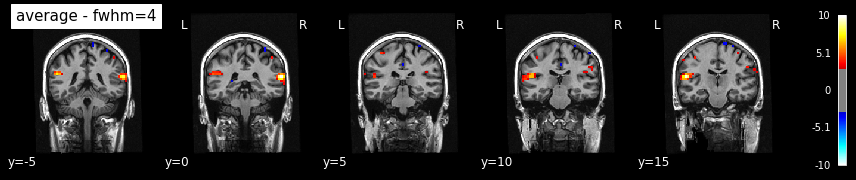

In [17]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

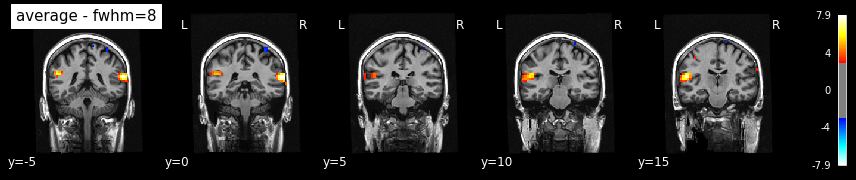

In [18]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

Now, let's look at the three contrasts **`Finger`**, **`Foot`**, **`Lips`**.

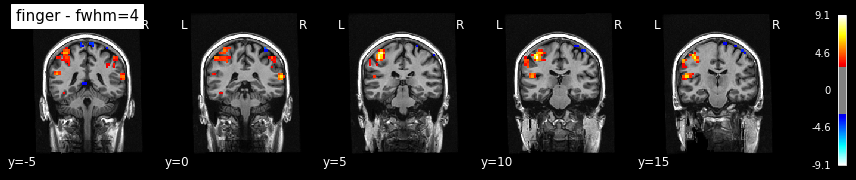

In [19]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0002.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

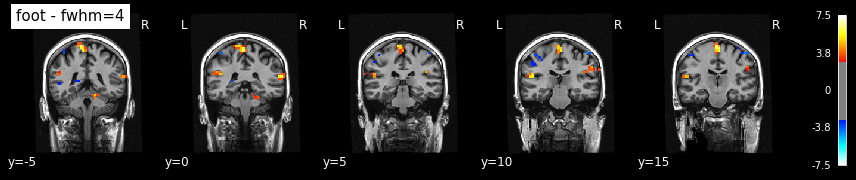

In [20]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0003.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

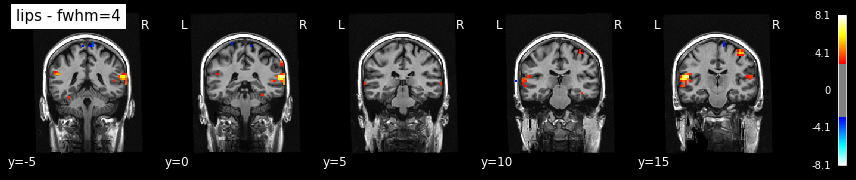

In [21]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0004.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

We can also check three additional contrasts **Finger > others**, **Foot > others** and **Lips > others**. 

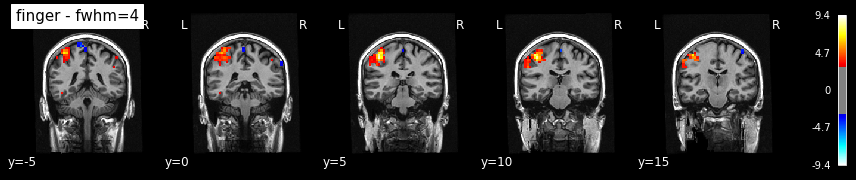

In [22]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0005.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

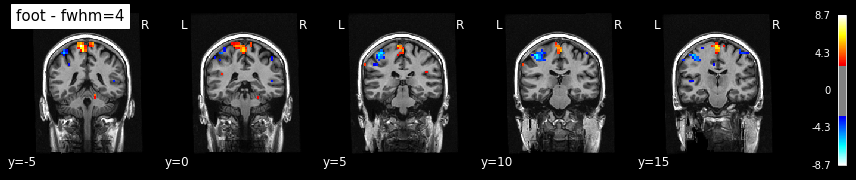

In [23]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0006.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

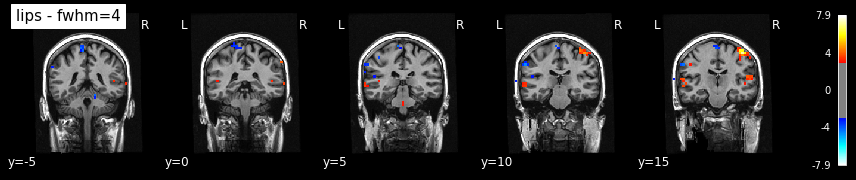

In [24]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0007.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

## Special case

There is something special with the **Finger** contrast in all subjects. So let's take a look at all of them.

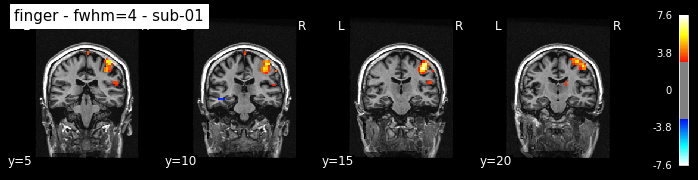

In [25]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-01',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

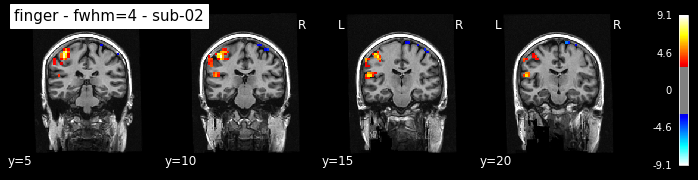

In [26]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-02/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-02',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

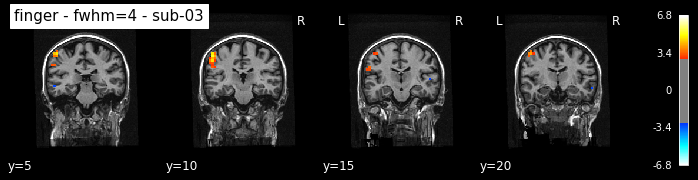

In [27]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-03/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-03',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

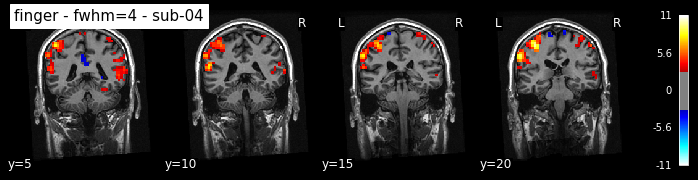

In [28]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-04/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-04',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

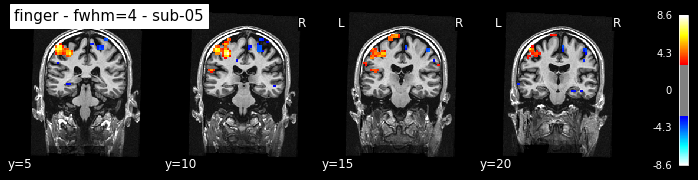

In [29]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-05/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-05',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

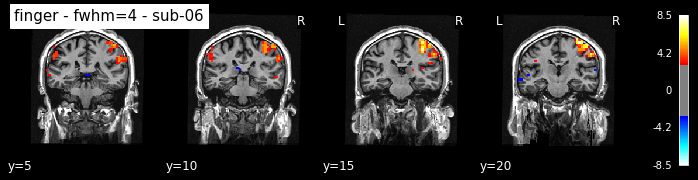

In [30]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-06/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-06',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

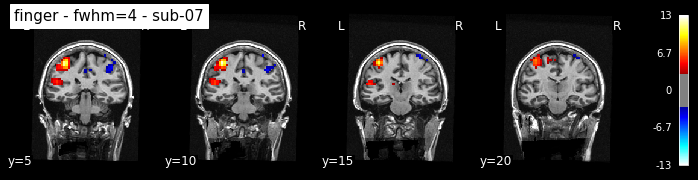

In [31]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-07/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-07',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

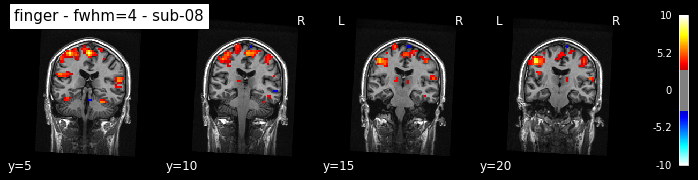

In [32]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-08/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-08',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

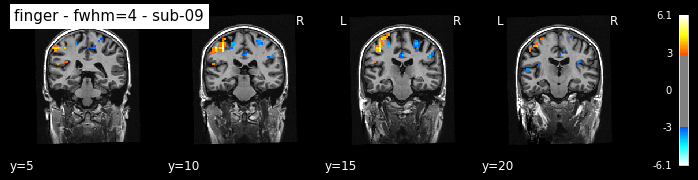

In [33]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-09/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-09',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

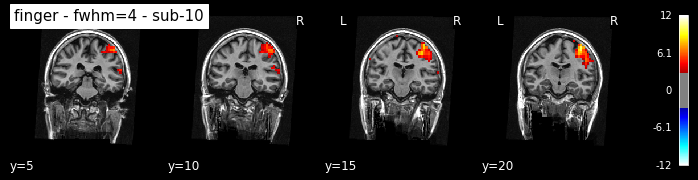

In [34]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-10/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-10',
    bg_img='/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-10/anat/sub-10_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

What you might see is that the hemisphere of the main cluster differs significantly between subjects. This is because all subjects were asked to use the dominant hand, either right or left. There were three subjects (``sub-01``, ``sub-06`` and ``sub-10``) that were left-handed. This can be seen in the pictures above, where we find the main cluster in the left hemisphere for right-handed subject and on the right hemisphere for left-handed subjects.

**Because of this, We will use only right-handed subjects for the following anlysis**.